# 1. Einleitung
Im folgenden Jupyter Notebook werden öffentlich verfügbare Daten des New Yorker Fahrradverleihs CitiBike analysiert und mit Verkehrsunfalldaten des NYPD kombiniert. CitiBike betreibt über 12.000 Fahrräder an rund 750 Verleihstationen und ist damit eine wichtige Ergänzung zu klassischen Verkehrsmitteln wie U-Bahn oder Taxi. Die detaillierten Fahrtdaten von CitiBike geben Aufschluss über Nutzerverhalten, Auslastung und räumlich-zeitliche Muster der Fahrradnutzung.

Ziel dieser Analyse ist es, aus der Verknüpfung von CitiBike- und NYPD-Unfalldaten wertvolle Erkenntnisse für potenzielle Kooperationen zwischen CitiBike und Versicherungen zu gewinnen. Dabei werden insbesondere Unfallrisiken im Umfeld von Verleihstationen, saisonale und demografische Muster sowie mögliche Präventions- und Versicherungsansätze untersucht. 

## Kooperationsansätze von CitiBike mit Versicherung

Durch die Verknüpfung von CitiBike-Fahrtdaten mit NYPD Unfalldaten lassen sich Hotspots und Zeiten mit erhöhtem Unfallrisiko für Radfahrer identifizieren. Basierend darauf könnten dynamische Tarife oder gezielte Präventionsangebote entwickelt werden:

- Versicherungsprodukte für Nutzer von CitiBike: Bei Buchung des Fahrrads könnten in der App direkt Kurzzeit-Unfallversicherungen oder Haftpflichtversicherungen angeboten werden.
- Präventionsmaßnahmen: Aus den Daten lassen sich Empfehlungen für sicheree Routen, Warnhinweise zu gefährlichen Kreuzungen oder gezielte Aufklärungskampagnen für bestimmte Nutzergruppe anbieten.
- Kundensegmentierung: Identifikation von unterschiedlichen Nutzerprofilen und Risikogruppen identifiziert werden, um maßgeschneiderte Versicherungsangebote zu erstellen.

# 2. Einladen der Daten und Datenpreprocessing

Die CitiBike Daten für Q1 2025 wurden heruntergeladen und können [hier](https://s3.amazonaws.com/tripdata/index.html) gefunden werden. Die Daten vom NYPD können [hier](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data) herunterladen werden.

In [1]:
# Importing packages for data cleaning and analysis
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load CitiBike datasets
citibike_jan = pd.read_csv("Data/JC-202501-citibike-tripdata.csv")
citibike_feb = pd.read_csv("Data/JC-202502-citibike-tripdata.csv")
citibike_mar = pd.read_csv("Data/JC-202503-citibike-tripdata.csv")

# Combine CitiBike data into one data frame
citibike = pd.concat([citibike_jan, citibike_feb, citibike_mar], ignore_index=True)

# Load NYPD Motor Vehicle Collisions dataset
NYPD_data = pd.read_csv("Data/Motor_Vehicle_Collisions_-_Crashes_20250429.csv")

# Inspecting data frames
print("Citibike Q1 shape:", citibike.shape)
print("Collisions shape:", NYPD_data.shape)

C:\Users\49152\AppData\Local\Temp\ipykernel_10760\1180896233.py:10: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  NYPD_data = pd.read_csv("Data/Motor_Vehicle_Collisions_-_Crashes_20250429.csv")


Citibike Q1 shape: (169159, 13)
Collisions shape: (2171897, 29)


In [3]:
# First drop duplicates from the Data
NYPD_data.drop_duplicates(inplace=True)
citibike.drop_duplicates(inplace=True)
# Inspecting data frames
print("Citibike Q1 shape:", citibike.shape)
print("Collisions shape:", NYPD_data.shape)

Citibike Q1 shape: (169159, 13)
Collisions shape: (2171897, 29)


In [4]:
# Get  citibike column names
column_names = citibike.columns.tolist()
print("Column names:", column_names)

# Get  NYPD column names
column_names = NYPD_data.columns.tolist()
print("Column names:", column_names)

# Rename columns in NYPD_data
NYPD_data.columns = NYPD_data.columns.str.lower().str.replace(' ', '_')

# Get  NYPD column names
column_names = NYPD_data.columns.tolist()
print("Column names:", column_names)

Column names: ['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']
Column names: ['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
Column names: ['crash_date', 'crash_time', 'borough', 'zip_code', 'latitude', 'longitude', 

In [5]:
# Clean CitiBike Data
# Drop rows without station names
citibike.dropna(subset=['start_station_name', 'end_station_name'], inplace=True)
# Drop rows without start or end name
citibike.dropna(subset=['started_at', 'ended_at'], inplace=True)


# Convert relevant columns to datetime objects
citibike['started_at'] = pd.to_datetime(citibike['started_at'])
citibike['ended_at'] = pd.to_datetime(citibike['ended_at'])


# Clean NYPD Data
# Drop rows with missing latitude and longitude
NYPD_data.dropna(subset=['latitude', 'longitude'], inplace=True)

# Convert relevant columns to correct data types
NYPD_data['date'] = pd.to_datetime(NYPD_data['crash_date'])
NYPD_data['time'] = pd.to_datetime(NYPD_data['crash_time'], format='%H:%M', errors='coerce').dt.time

# Drop rows with invalid times (coerced to NaT)
NYPD_data.dropna(subset=['time'], inplace=True)

print("Cleaned Citibike Q1 shape:", citibike.shape)
print("Cleaned Collisions shape:", NYPD_data.shape)

Cleaned Citibike Q1 shape: (168797, 13)
Cleaned Collisions shape: (1932014, 31)


In [ ]:
# Filter NYPD data for accidents involving cyclists and occurring between January and March 2025
cyclist_accidents = NYPD_data[
    (NYPD_data['number_of_cyclist_injured'] > 0) | (NYPD_data['number_of_cyclist_killed'] > 0)
]

cyclist_accidents_q1_2025 = cyclist_accidents[
    (cyclist_accidents['date'] >= '2025-01-01') & (cyclist_accidents['date'] <= '2025-03-31')
]

# getting the hour of the day of the accidents
cyclist_accidents_q1_2025['hour'] = cyclist_accidents_q1_2025['time'].apply(lambda x: x.hour)

# Calculate Trip Duration in Minutes for Citibike data
citibike['duration_minutes'] = (citibike['ended_at'] - citibike['started_at']).dt.total_seconds() / 60

# 3. Datenexploration und Visualisierung

In diesem Abschnitt werden wir die beiden zu analysierenden Datensätze – den Citibike-Datensatz aus New York City und die Unfalldaten – einer ersten Datenexploration und Visualisierung unterziehen. Ziel ist es, ein grundlegendes Verständnis für die enthaltenen Informationen zu gewinnen, zentrale Merkmale und Muster zu erkennen sowie potenzielle Zusammenhänge sichtbar zu machen.

## 3.1 CitiBike Datensatz


### Was sind die Top10 Start- und Endstationen?


Analyzing CitiBike Usage Patterns:
start_station_name
Grove St PATH                               8159
Hoboken Terminal - River St & Hudson Pl     8030
Newport PATH                                4414
City Hall - Washington St & 1 St            4135
Bergen Ave & Sip Ave                        4031
Hamilton Park                               3687
Exchange Pl                                 3446
Hoboken Terminal - Hudson St & Hudson Pl    3421
River St & 1 St                             3392
8 St & Washington St                        3352
Name: count, dtype: int64


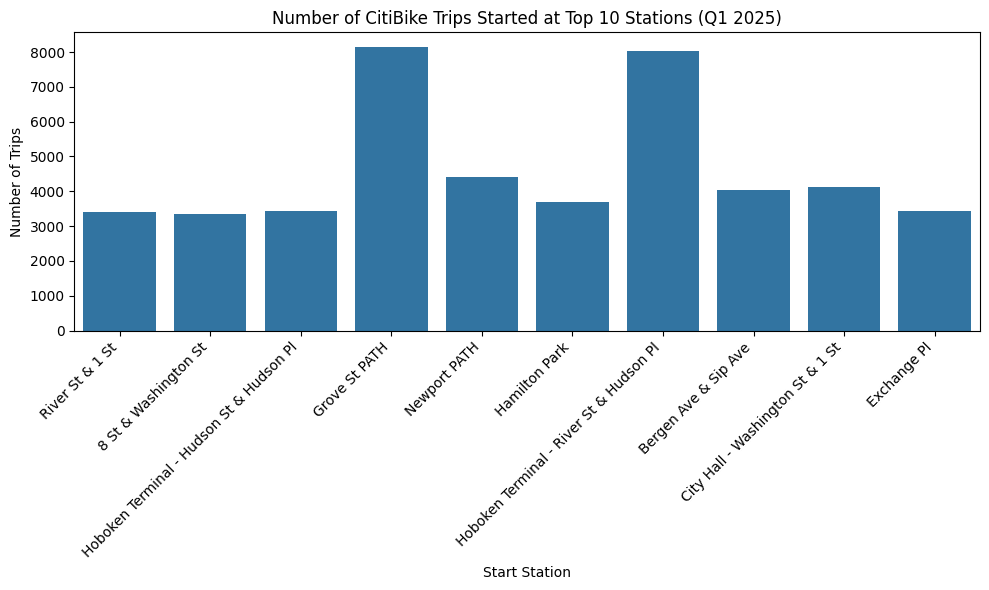

end_station_name
Grove St PATH                               8945
Hoboken Terminal - River St & Hudson Pl     8713
Newport PATH                                4423
City Hall - Washington St & 1 St            4171
Bergen Ave & Sip Ave                        4035
Hamilton Park                               3739
Exchange Pl                                 3561
River St & 1 St                             3310
Hoboken Terminal - Hudson St & Hudson Pl    3268
8 St & Washington St                        3268
Name: count, dtype: int64


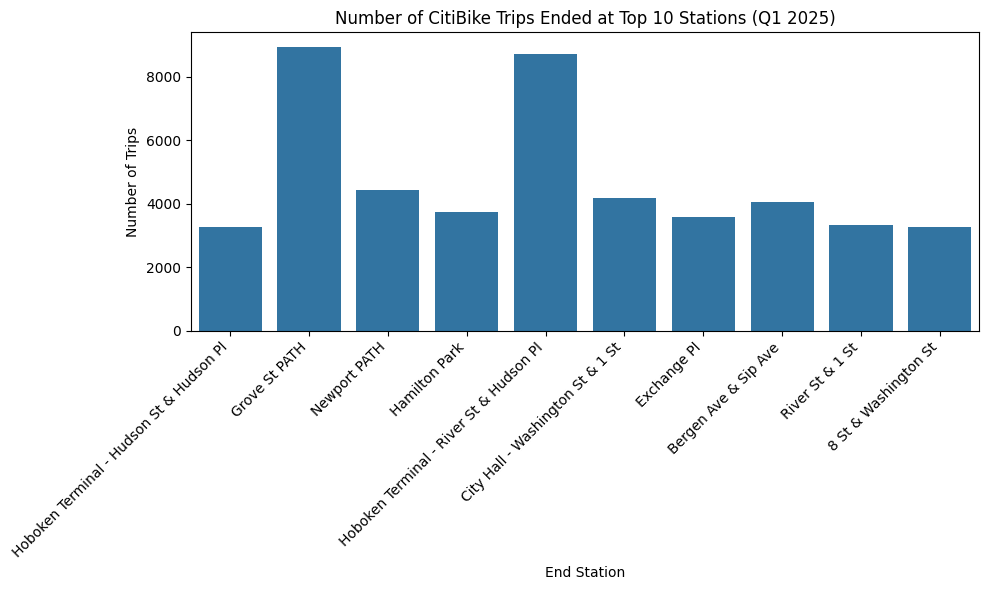

In [7]:
print("\nAnalyzing CitiBike Usage Patterns:")
print(citibike['start_station_name'].value_counts().head(10))  # Top 10 start stations

plt.figure(figsize=(10, 6))
top_10_stations = citibike['start_station_name'].value_counts().nlargest(10).index
sns.countplot(x='start_station_name', data=citibike[citibike['start_station_name'].isin(top_10_stations)])
plt.title('Number of CitiBike Trips Started at Top 10 Stations (Q1 2025)')
plt.xlabel('Start Station')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print(citibike['end_station_name'].value_counts().head(10))  # Top 10 start stations

plt.figure(figsize=(10, 6))
top_10_stations = citibike['end_station_name'].value_counts().nlargest(10).index
sns.countplot(x='end_station_name', data=citibike[citibike['end_station_name'].isin(top_10_stations)])
plt.title('Number of CitiBike Trips Ended at Top 10 Stations (Q1 2025)')
plt.xlabel('End Station')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

Die aufgeführten Stationen befinden sich hauptsächlich in New Jersey, insbesondere in Jersey City und Hoboken, nicht in New York City. Das Citi Bike-System bedient zwar Teile von New York City (Manhattan, Brooklyn, Queens, Bronx), ist aber auch auf der anderen Seite des Hudson River in diesen Städten von New Jersey stark vertreten. Viele dieser Stationen sind mit dem PATH-Zugsystem verbunden, das New Jersey mit Manhattan verbindet.

* Wichtige Verkehrsknotenpunkte: Bahnhöfe wie Grove St PATH, Hoboken Terminal - River St & Hudson Pl, Newport PATH und Exchange Pl dominieren eindeutig sowohl beim Beginn als auch beim Ende von Fahrten. Dies liegt daran, dass sie sich an wichtigen PATH-Bahnhöfen und Verkehrsknotenpunkten befinden. Die Menschen nutzen Citi Bikes wahrscheinlich für die „letzte Meile“ ihres Weges - die Fahrt vom Bahnhof zum Büro oder nach Hause und andersherum. Der Hoboken Terminal ist ein besonders großer Knotenpunkt, der PATH-Züge, NJ Transit-Züge, Busse und Fähren miteinander verbindet.
* Hohe Dichte / beliebte Gebiete: Die hohen Nutzungszahlen deuten darauf hin, dass sich diese Bahnhöfe in dicht besiedelten Wohngebieten, Geschäftsvierteln oder an Orten mit hohem Fußgängeraufkommen befinden.
* Symmetrie in der Nutzung: Die Tatsache, dass die wichtigsten Startbahnhöfe fast identisch mit den wichtigsten Endbahnhöfen sind (und in einer sehr ähnlichen Reihenfolge), deutet darauf hin, dass diese Orte sowohl als Ausgangspunkt als auch als Ziel dienen. Dies unterstreicht ihre Rolle als zentrale Knotenpunkte für den Pendler- und Nahverkehr. Viele Fahrten, die an diesen Knotenpunkten beginnen, enden auch wieder an einem von ihnen.


### Wie ist die Verteilung der Fahrten über den Monat und den Tag?

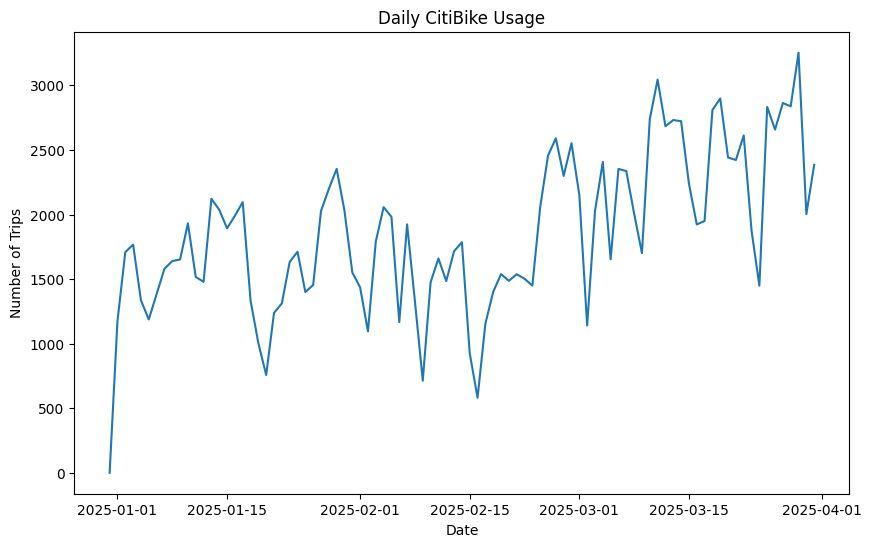

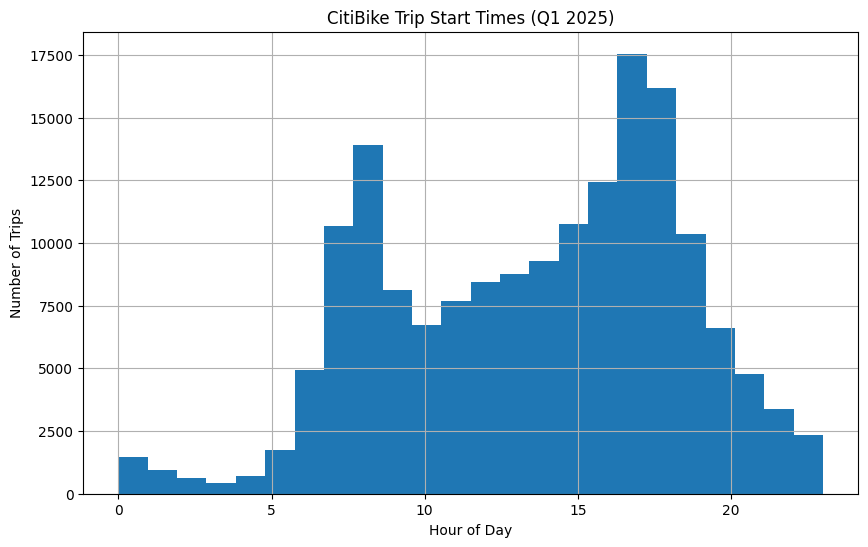

In [8]:
# Daily Citibike trips
citibike['date'] = citibike['started_at'].dt.date # Use date for daily analysis
daily_counts = citibike.groupby('date').size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='counts', data=daily_counts)
plt.title('Daily CitiBike Usage')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()#

# Hourly Citbike trips
plt.figure(figsize=(10, 6))
citibike['started_at'].dt.hour.hist(bins=24)  # Hourly usage pattern
plt.title('CitiBike Trip Start Times (Q1 2025)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.show()

In der ersten Abbildung sind die Gesamtzahl der Trips gegen das Datum aus dem ersten Quartal 2025 dargestellt. Es gibt einen allgemeinen Aufwärtstrend bei den täglichen Fahrten von Anfang Januar bis Ende März. Dies deutet auf einen Anstieg der Fahrgastzahlen hin, da sich das Wetter mit dem Übergang vom Winter in den frühen Frühling wahrscheinlich verbessert. Das auffälligste Muster ist ein klarer Wochenzyklus. Es sind regelmäßige Spitzen und Tiefpunkte zu erkennen. Die Spitzenwerte entsprechen wahrscheinlich den Wochentagen (Montag-Freitag), an denen die Pendlernutzung am höchsten ist, während die Tiefpunkte die Wochenenden (Samstag-Sonntag) darstellen, an denen die Fahrgastzahlen, insbesondere im Pendlerverkehr, tendenziell abnehmen. Die Nutzung beginnt sehr niedrig am 1. Januar, was aufgrund des Neujahrsfeiertags und des typischerweise kalten Wetters zu erwarten ist. Während das wöchentliche Muster stark ausgeprägt ist, gibt es innerhalb der Wochentage und Wochenenden immer noch Schwankungen von Tag zu Tag. Dies könnte durch Faktoren wie bestimmte Wetterbedingungen (Regen, Schnee, extreme Kälte würden die Nutzung verringern), Feiertage (wie z. B. der Presidents' Day im Februar, der einen Einbruch verursacht) oder bestimmte Ereignisse beeinflusst werden. So könnte der spürbare Einbruch gegen Ende Februar mit einer Schlechtwetterperiode oder einem Feiertagswochenende zusammenhängen. Die Spitzen- und Tiefstwerte nehmen im Allgemeinen im Laufe der Zeit zu, was die Idee einer zunehmenden saisonalen Nutzung untermauert. Die höchsten Nutzungstage treten gegen Ende März auf.

Das zweite Histogramm zeigt die Verteilung der Startzeiten von Citi Bike-Fahrten über einen 24-Stunden-Tag, aggregiert über das gesamte erste Quartal (Q1) 2025. Die x-Achse stellt die Stunde des Tages dar (0 = Mitternacht, 17 = 17 Uhr), und die y-Achse die Gesamtzahl der Fahrten, die während dieser Stunde über den gesamten Zeitraum gestartet wurden. Die Verteilung ist eindeutig bimodal, d. h. sie weist zwei deutliche Spitzenwerte auf. Dies ist charakteristisch für Verkehrssysteme, die stark für den Berufsverkehr genutzt werden. Es gibt eine deutliche Spitze zwischen 7 Uhr und 9 Uhr (Stunden 7-8). Dies entspricht der typischen morgendlichen Pendlerzeit, in der die Menschen mit dem Fahrrad zur Arbeit, zur Schule oder zu Transitstationen (wie den bereits erwähnten PATH-Stationen) fahren.  Eine größere, etwas breitere Spitze tritt am späten Nachmittag/frühen Abend auf, etwa zwischen 16 und 19 Uhr (Stunde 16-18), mit dem höchsten Punkt um 17 Uhr (Stunde 17). Dies entspricht dem abendlichen Heimweg. Die abendlichen Spitzenwerte sind oft höher und breiter gestreut als die morgendlichen Spitzenwerte, da die Abfahrtszeiten der Menschen von der Arbeit stärker variieren können als ihre Ankunftszeiten. In den späten Nacht- und frühen Morgenstunden (etwa zwischen Mitternacht und 5 Uhr morgens) ist die Nutzung extrem gering. In der Mitte des Tages (etwa zwischen 10 und 15 Uhr) ist die Nutzung mäßig, aber deutlich geringer als zu den Spitzenzeiten im Berufsverkehr. Dabei handelt es sich wahrscheinlich um Fahrten zum Mittagessen, Besorgungen, Besprechungen oder Fahrten, die nicht mit dem Berufsverkehr zusammenhängen.


### Wie lange sind die Trips und gibt es Unterschiede zwischen den Usertypen?


Descriptive statistics of trip duration:
Mean: 7.557360953689935 
Median: 5.36395 
Mode: 3.190816666666667 
Std Dev: 16.933152585426598 
Range : 1468.4351333333334


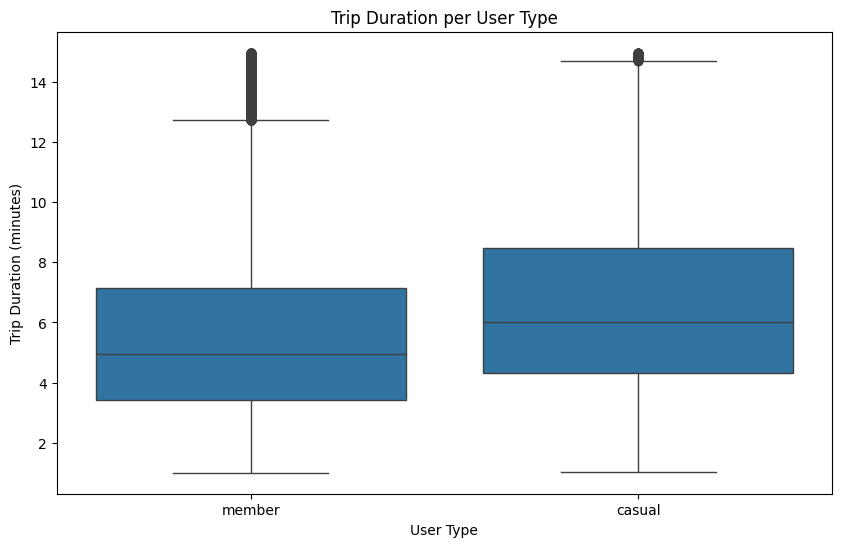

In [9]:
# Trip duration
# Descriptive statistics of trip duration
print("\nDescriptive statistics of trip duration:")
mean_duration = citibike['duration_minutes'].mean()
median_duration = citibike['duration_minutes'].median()
mode_duration = citibike['duration_minutes'].mode()[0]
std_dev_duration = citibike['duration_minutes'].std()  # Standard Deviation
range_durtion = citibike['duration_minutes'].max() - citibike['duration_minutes'].min()  # Range
print("Mean:", mean_duration, "\nMedian:", median_duration, "\nMode:", mode_duration,"\nStd Dev:", std_dev_duration, "\nRange :", range_durtion)


# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered


# Remove outliers for trip duration
citibike_no_outliers = remove_outliers_iqr(citibike, 'duration_minutes')

# Boxplot of average trip duration per user type
plt.figure(figsize=(10, 6))
sns.boxplot(x='member_casual', y='duration_minutes', data=citibike_no_outliers)
plt.title('Trip Duration per User Type')
plt.xlabel('User Type')
plt.ylabel('Trip Duration (minutes)')
plt.show()

In dieser Abbildung wird die Verteilung der Fahrtdauer (in Minuten) für zwei verschiedene Arten von Citi Bike-Nutzern dargestellt: Mitglieder (Abonnenten) und Gelegenheitsnutzer (mit Einzelfahrten oder Tageskarten). Dies hilft beim Vergleich typischer Fahrtenlängen und der Variabilität der Fahrzeiten zwischen diesen Gruppen. Ausreißer wurden zur besseren Visualisierung mit der IQR-Methode entfernt. Der Interquartilsbereich (IQR) misst die Streuung der mittleren 50 % der Daten und stellt den Bereich zwischen dem 25. Perzentil (Q1) und dem 75. Die Grafik zeigt,  dass Gelegenheitsnutzer tendenziell längere Fahrten mit dem Citi Bike unternehmen als Mitglieder. Die Mitglieder, oft Pendler, neigen zu kürzeren, gleichmäßigeren Fahrten, die möglicherweise direkte Fahrten von A nach B widerspiegeln. Gelegenheitsnutzer nutzen die Fahrräder möglicherweise eher für Freizeitaktivitäten, Besichtigungen oder weniger direkte Strecken, was zu längeren durchschnittlichen Fahrzeiten führt.

### Zusammenfassung
Die Analyse zeigt, dass die wichtigsten Citi Bike-Stationen im Untersuchungsgebiet vor allem in New Jersey liegen, insbesondere in Jersey City und Hoboken. Diese Stationen befinden sich an zentralen Verkehrsknotenpunkten, meist in direkter Nähe zu PATH-Bahnhöfen, die New Jersey mit Manhattan verbinden. Die hohe Nutzung an diesen Standorten deutet auf eine starke Funktion als „letzte Meile“-Verbindung für Pendler hin. Die Auswertung der Fahrtdaten zeigt einen wöchentlichen Zyklus mit Spitzen an Werktagen und geringerer Nutzung am Wochenende sowie einen saisonalen Anstieg der Fahrten vom Winter in den Frühling. Die Verteilung der Startzeiten ist klar bimodal mit deutlichen Spitzen am Morgen und Abend, was die Bedeutung des Systems für den Berufsverkehr unterstreicht. Mitglieder nutzen Citi Bike meist für kürzere, regelmäßige Fahrten, während Gelegenheitsnutzer zu längeren Fahrten tendieren, oft außerhalb der Pendlerzeiten.

## 3.2 NYPD Datensatz

### Wie viele Personen wurden verletzt oder getötet bei Fahrradunfällen im ersten Quartal 2025?

In [10]:
# Summary statistics for the whole dataframe
print("Summary Statistics for all data:")
# Descriptive statistics
print("\nDescriptive statistics of Cyclist injured:")
mean_duration = NYPD_data['number_of_cyclist_injured'].mean()
median_duration = NYPD_data['number_of_cyclist_injured'].median()
mode_duration = NYPD_data['number_of_cyclist_injured'].mode()[0]
std_dev_duration = NYPD_data['number_of_cyclist_injured'].std()  # Standard Deviation
range_durtion = NYPD_data['number_of_cyclist_injured'].max() - NYPD_data['number_of_cyclist_injured'].min()  # Range
print("\nMean:", mean_duration, "\nMedian:", median_duration, "\nMode:", mode_duration,"\nStd Dev:", std_dev_duration, "\nRange :", range_durtion)

print("\nDescriptive statistics of Cyclist killed:")
mean_duration = NYPD_data['number_of_cyclist_killed'].mean()
median_duration = NYPD_data['number_of_cyclist_killed'].median()
mode_duration = NYPD_data['number_of_cyclist_killed'].mode()[0]
std_dev_duration = NYPD_data['number_of_cyclist_killed'].std()  # Standard Deviation
range_durtion = NYPD_data['number_of_cyclist_killed'].max() - NYPD_data['number_of_cyclist_killed'].min()  # Range
print("\nMean:", mean_duration, "\nMedian:", median_duration, "\nMode:", mode_duration,"\nStd Dev:", std_dev_duration, "\nRange :", range_durtion)


Summary Statistics for all data:

Descriptive statistics of Cyclist injured:

Mean: 0.029380739477043127 
Median: 0.0 
Mode: 0 
Std Dev: 0.1709065040292811 
Range : 4

Descriptive statistics of Cyclist killed:

Mean: 0.00012215232394796312 
Median: 0.0 
Mode: 0 
Std Dev: 0.011098317696715003 
Range : 2


Im Durchschnitt werden pro Unfall nur wenige Radfahrer verletzt und tödliche Unfälle waren selten.

### In welchem Stadtteil gab es die meisten Unfälle?


Analyzing Accident Frequency and Location:
borough
MANHATTAN        263
BROOKLYN         239
QUEENS           120
BRONX             69
STATEN ISLAND      2
Name: count, dtype: int64


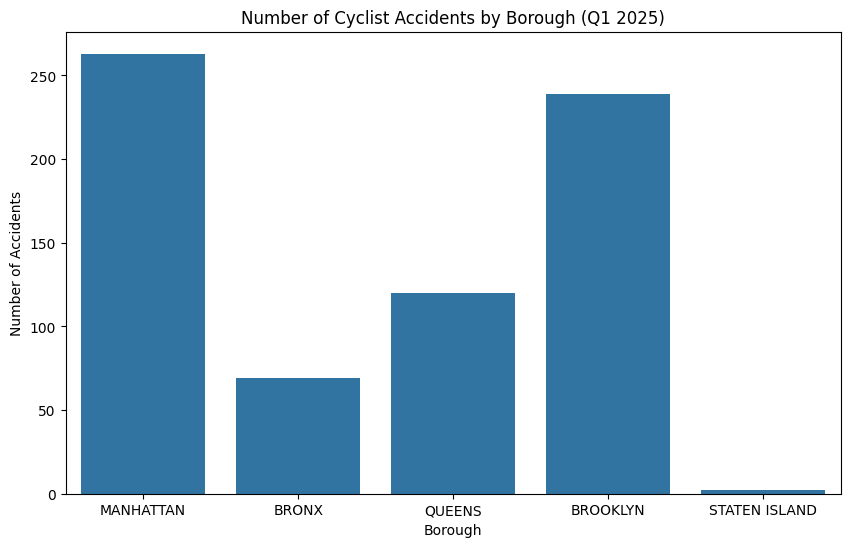

In [11]:
# Accident Frequency and Location
print("\nAnalyzing Accident Frequency and Location:")
print(cyclist_accidents_q1_2025['borough'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='borough', data=cyclist_accidents_q1_2025)
plt.title('Number of Cyclist Accidents by Borough (Q1 2025)')
plt.xlabel('Borough')
plt.ylabel('Number of Accidents')
plt.show()


Dieses Diagramm vergleicht die Gesamtzahl der gemeldeten Radfahrerunfälle in den fünf Bezirken von New York City (Manhattan, Bronx, Queens, Brooklyn und Staten Island) für den Zeitraum vom 1. Januar bis 31. März 2025. Jeder Balken steht für einen Stadtbezirk, und seine Höhe entspricht der Anzahl der dort registrierten Unfälle.

* Manhattan verzeichnete im ersten Quartal 2025 mit rund 265 Unfällen die meisten Radfahrerunfälle. Brooklyn folgte mit rund 240 Unfällen sehr dicht dahinter. In diesen beiden Bezirken ereigneten sich in diesem Zeitraum eindeutig die meisten Radfahrerunfälle.
* Auch in Queens gab es eine beträchtliche Anzahl von Unfällen, etwa 120. Das ist etwa halb so viel wie in Manhattan oder Brooklyn, aber deutlich mehr als in den übrigen Stadtbezirken.
* In der Bronx war die Zahl der Unfälle im Vergleich zu den drei führenden Bezirken mit insgesamt etwa 70 Vorfällen deutlich geringer.
* Auf Staten Island gab es nur sehr wenige Radfahrerunfälle, anscheinend nur 2 oder 3 für das gesamte Quartal. Im Vergleich zu den anderen Stadtbezirken ist die Zahl fast vernachlässigbar.

Dies könnte folgende Gründe haben:

* Radverkehrsaufkommen und -dichte: Die hohen Zahlen in Manhattan und Brooklyn stehen wahrscheinlich in engem Zusammenhang mit der viel höheren Dichte an Radfahrern (Pendler, Zusteller, Freizeitradler) und der allgemeinen Verkehrsbelastung in diesen Bezirken im Vergleich zu anderen. Mehr Fahrräder und mehr Fahrzeuge, die in einem dichten städtischen Umfeld aufeinandertreffen, führen im Allgemeinen zu mehr potenziellen Konflikten und Unfällen.
* Infrastruktur: Manhattan und Brooklyn verfügen zwar über ein ausgedehntes Radwegenetz, haben aber auch ein komplexes Straßennetz, starken Autoverkehr und zahlreiche Kreuzungen, die für Radfahrer eine Herausforderung darstellen können. Die Zahl der Unfälle bedeutet nicht unbedingt, dass dies die gefährlichsten Orte pro gefahrenen Kilometer sind, sondern eher, wo die meisten Unfälle insgesamt passieren.
* Unterschiede zwischen den Bezirken: Queens ist geografisch groß und weist eine unterschiedliche Dichte auf; die Zahl der Unfälle spiegelt eine beträchtliche Fahrradaktivität wider, die aber vielleicht weniger konzentriert ist als in Manhattan oder im Zentrum Brooklyns. Die niedrigeren Zahlen in der Bronx und vor allem auf Staten Island spiegeln wahrscheinlich ein geringeres Gesamtradverkehrsaufkommen, ein weniger dichtes Straßennetz und möglicherweise ein anderes Verkehrsverhalten wider (z. B. eine höhere Autoabhängigkeit auf Staten Island).

### Wann gab es die meisten Unfälle?

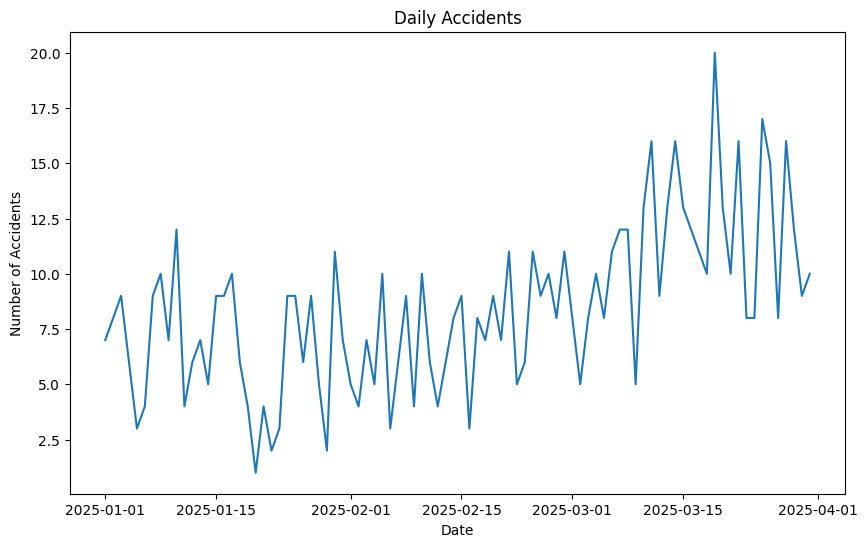

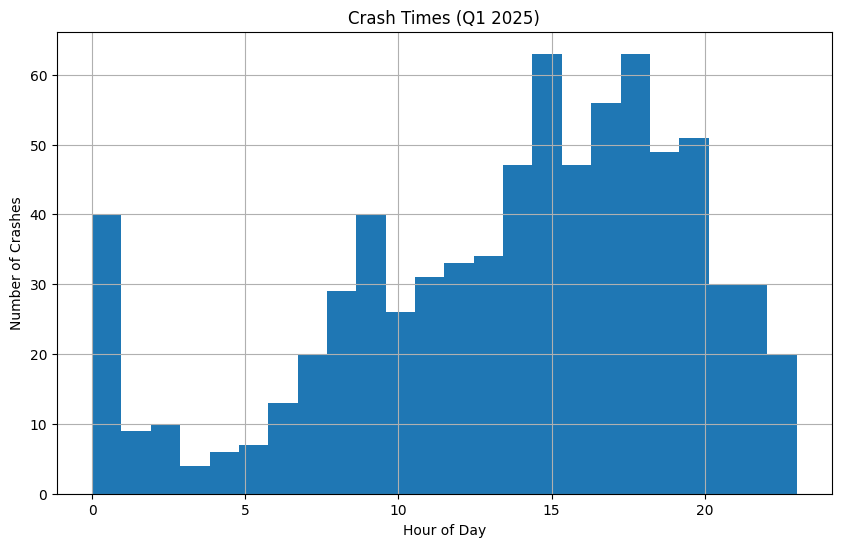

In [12]:
# Accidents over time
daily_accidents = cyclist_accidents_q1_2025.groupby(cyclist_accidents_q1_2025['date'].dt.date).size().reset_index(name='counts')
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", y="counts", data=daily_accidents)
plt.title("Daily Accidents")
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.show()

plt.figure(figsize=(10, 6))
cyclist_accidents_q1_2025['hour'].hist(bins=24)  # Hourly usage pattern
plt.title('Crash Times (Q1 2025)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crashes')
plt.show()

Die erste Abbildung zeigt die Gesamtzahl der täglich gemeldeten Radfahrerunfälle vom 1. Januar 2025 bis zum 1. April 2025. Die y-Achse ist die Anzahl der Unfälle, die x-Achse das Datum. Ähnlich wie beim Diagramm der täglichen Citi Bike-Nutzung scheint es einen allgemeinen Aufwärtstrend bei der Anzahl der täglichen Unfälle von Januar bis März zu geben. Dies deutet darauf hin, dass mit der möglichen Verbesserung des Wetters und der Zunahme der Fahrradnutzung auch die Zahl der Unfälle zunahm. Das Diagramm zeigt, dass die Unfallzahlen von Tag zu Tag erheblich schwanken. An manchen Tagen ereignen sich nur 1-2 Unfälle (z. B. Mitte Januar), während an anderen Tagen die Zahl der Unfälle bei 20 liegt (Ende März). Obwohl weniger ausgeprägt als im Nutzungsdiagramm, könnte es ein subtiles wöchentliches Muster geben. Die Spitzenwerte könnten häufiger auf Wochentage fallen, an denen das Radverkehrsaufkommen (insbesondere im Berufsverkehr) höher ist, und die Tiefstwerte auf Wochenenden, aber aufgrund der Schwankungen ist dies weniger eindeutig als das Nutzungsmuster. Externe Faktoren wie das Wetter (an regnerischen Tagen gibt es möglicherweise weniger Radfahrer und damit auch weniger Unfälle) spielen wahrscheinlich eine wichtige Rolle bei den täglichen Schwankungen. Die höchsten Spitzenwerte treten später im Quartal (März) auf, was mit dem wahrscheinlichen Anstieg der Gesamtfahrradaktivität korreliert, der in den vorherigen Nutzungsdiagrammen zu sehen ist.

Die zweite Abbildung zeigt die Verteilung der Radfahrerunfälle auf der Grundlage der Tageszeit, zu der sie sich ereigneten, aggregiert über das gesamte erste Quartal 2025. Die x-Achse stellt die Stunde dar (0 = Mitternacht, 16 = 16 Uhr), und die y-Achse zeigt die Gesamtzahl der Unfälle in dieser Stunde während des Quartals. Die Verteilung spiegelt stark das Nutzungsmuster des Citi Bike wider und zeigt deutliche Spitzenwerte während der typischen Pendlerzeiten. Es gibt eine deutliche Spitze zwischen 8 und 10 Uhr morgens (Stunden 8-9), die mit dem morgendlichen Pendlerverkehr übereinstimmt. Eine viel größere und breitere Spitze tritt am Nachmittag und Abend auf, die um 15 Uhr (Stunde 15) beginnt und bis etwa 20 Uhr (Stunde 20) andauert. Die meisten Unfälle ereignen sich zwischen 16 Uhr und 19 Uhr (16-18 Uhr). Dies entspricht dem abendlichen Pendlerverkehr und ist wahrscheinlich auf Faktoren wie ein höheres Gesamtverkehrsaufkommen, Müdigkeit und möglicherweise abnehmende Sichtverhältnisse am Ende des Tages zurückzuführen. Ähnlich wie bei der Nutzung ist die Unfallhäufigkeit in den späten Nacht- und frühen Morgenstunden (ca. 1 Uhr bis 5 Uhr) sehr gering. In den Mittagsstunden (ca. 10 bis 15 Uhr) ereignen sich mäßig viele Unfälle, mehr als in der Nacht, aber deutlich weniger als in der Abendspitze. Interessanterweise gibt es einen deutlichen Anstieg der Unfälle in der Mitternachtsstunde (Stunde 0). Dies könnte möglicherweise damit zusammenhängen, dass die Menschen erst spät von abendlichen Aktivitäten nach Hause kommen.

### Zusammenfassung
Im ersten Quartal 2025 wurden in New York City die meisten Radfahrerunfälle in Manhattan und Brooklyn registriert, gefolgt von Queens, während die Zahlen in der Bronx und besonders auf Staten Island deutlich niedriger ausfielen. Trotz der insgesamt hohen Unfallzahlen war die durchschnittliche Zahl der Verletzten pro Unfall gering, tödliche Unfälle waren selten. Die meisten Unfälle ereigneten sich während der Pendlerzeiten am Morgen und Abend, wobei ein leichter Anstieg der Unfallzahlen im Verlauf des Quartals zu beobachten war – vermutlich bedingt durch besseres Wetter und zunehmende Fahrradaktivität. Die Unterschiede zwischen den Bezirken spiegeln vor allem das unterschiedliche Radverkehrsaufkommen und die jeweiligen infrastrukturellen Bedingungen wider.

## 4. Kooperationsansätze von CitiBike mit Versicherung

Die explorative Datenanalsye hat gezeigt, dass sowohl Zeit als auch Stadtteil einen Einfluss auf die Unfallhäufigkeit der CitiBike Nutzer haben könnte. 


In [ ]:
# Combine date and time and convert to Datetime objects
try:
    # Create a combined datetime column
    cyclist_accidents_q1_2025['crash_datetime'] = pd.to_datetime(
        cyclist_accidents_q1_2025['crash_date'] + ' ' + cyclist_accidents_q1_2025['crash_time'],
        errors='coerce' # Creates NaT (Not a Time) for errors
    )
    # Remove rows where conversion failed
    cyclist_accidents_q1_2025.dropna(subset=['crash_datetime'], inplace=True)
    print(f"{len(cyclist_accidents_q1_2025)} accidents after time conversion.")
except KeyError:
     print("Error: Columns 'crash_date' or 'crash_time' not found in the accident data.")
     exit()
except Exception as e:
    print(f"Error combining/converting accident time: {e}")
    exit()

# Extract hour, weekday, and month
# Citibike data
citibike.loc[:, 'hour'] = citibike['started_at'].dt.hour
citibike.loc[:, 'weekday'] = citibike['started_at'].dt.dayofweek # Monday=0, Sunday=6
citibike.loc[:, 'month'] = citibike['started_at'].dt.month

# NYPD data
cyclist_accidents_q1_2025.loc[:, 'hour'] = cyclist_accidents_q1_2025['crash_datetime'].dt.hour
cyclist_accidents_q1_2025.loc[:, 'weekday'] = cyclist_accidents_q1_2025['crash_datetime'].dt.dayofweek # Monday=0, Sunday=6
cyclist_accidents_q1_2025.loc[:, 'month'] = cyclist_accidents_q1_2025['crash_datetime'].dt.month

# Summarize trips
trips_by_hour = citibike.groupby('hour').size().reset_index(name='number_of_trips')
trips_by_weekday = citibike.groupby('weekday').size().reset_index(name='number_of_trips')
trips_by_month = citibike.groupby('month').size().reset_index(name='number_of_trips')

# Summarize accidents
accidents_by_hour = cyclist_accidents_q1_2025.groupby('hour').size().reset_index(name='number_of_accidents')
accidents_by_weekday = cyclist_accidents_q1_2025.groupby('weekday').size().reset_index(name='number_of_accidents')
accidents_by_month = cyclist_accidents_q1_2025.groupby('month').size().reset_index(name='number_of_accidents')

In [16]:
# Correlation between time, trips and accidents
# Function to merge and correlate
def analyze_correlation(trips_agg, accidents_agg, time_unit):
    if trips_agg is None or accidents_agg is None:
        print(f"Error: Aggregated data for '{time_unit}' is missing.")
        return None, None

    # Merge the aggregated data based on the time unit
    comparison_df = pd.merge(
        trips_agg,
        accidents_agg,
        on=time_unit,
        how='outer' # 'outer' keeps all hours/days/months, even if only present in one dataset
    ).fillna(0) # Fill missing values (where there were no trips/accidents) with 0

    # Calculate the correlation
    # Check if there are enough data points (>1) and variance
    if len(comparison_df) > 1 and comparison_df['number_of_trips'].std() > 0 and comparison_df['number_of_accidents'].std() > 0:
         correlation = comparison_df['number_of_trips'].corr(comparison_df['number_of_accidents'])
    else:
        correlation = None
        print(f"Warning: Correlation for '{time_unit}' cannot be calculated (too few data points or no variance).")

    return comparison_df, correlation

# Analysis per hour
hourly_comparison, hourly_correlation = analyze_correlation(
    trips_by_hour if 'trips_by_hour' in locals() else None,
    accidents_by_hour if 'accidents_by_hour' in locals() else None,
    'hour'
)

# Analysis per weekday
weekday_comparison, weekday_correlation = analyze_correlation(
    trips_by_weekday if 'trips_by_weekday' in locals() else None,
    accidents_by_weekday if 'accidents_by_weekday' in locals() else None,
    'weekday'
)



Interpretation der Korrelation

Ein Korrelationskoeffizient von +1 bedeutet, dass mehr Fahrten tendenziell mit mehr Unfällen verbunden sind.
Ein Koeffizient  von 0 bedeutet, dass wenig bis gar kein linearer Zusammenhang besteht.
Ein Koeffizient von -1 würde bedeuten, dass mehr Fahrten mit weniger Unfällen verbunden sind (in diesem Zusammenhang unwahrscheinlich

In [17]:
if hourly_correlation is not None and hourly_correlation > 0.5:
    print("\nThe hourly correlation is positive and moderate to strong.")
    print("This suggests that hours with high CitiBike usage (like morning and evening commute times) also tend to be hours with more accidents.")
elif hourly_correlation is not None:
     print("\nThe hourly correlation exists, but might not be very strong.")
     print("Other factors besides the sheer number of trips could play an important role in accidents.")

if weekday_correlation is not None and weekday_correlation > 0.5:
    print("\nThe correlation by weekday is also positive.")
    print("This could indicate that weekdays (typically higher usage) show more accidents compared to weekends, proportional to usage.")




The hourly correlation is positive and moderate to strong.
This suggests that hours with high CitiBike usage (like morning and evening commute times) also tend to be hours with more accidents.

The correlation by weekday is also positive.
This could indicate that weekdays (typically higher usage) show more accidents compared to weekends, proportional to usage.


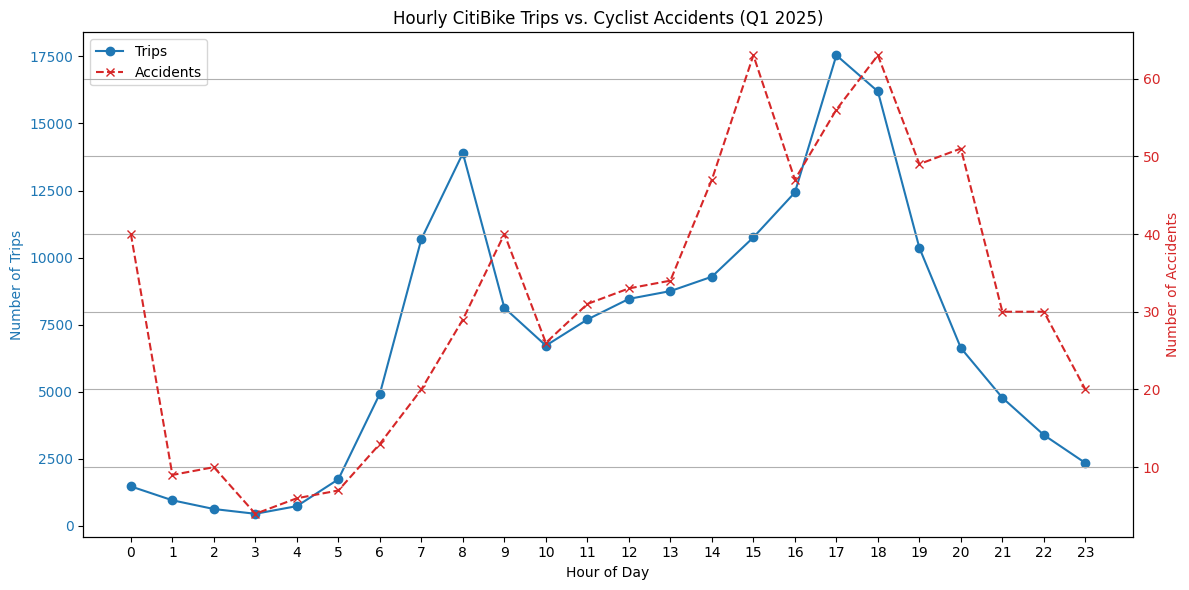

In [18]:
fig, ax1 = plt.subplots(figsize=(12, 6))
color1 = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Trips', color=color1)
line1 = ax1.plot(hourly_comparison['hour'], hourly_comparison['number_of_trips'], color=color1, marker='o', linestyle='-', label='Trips')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(np.arange(0, 24, 1)) # Ensure all hours are shown as ticks

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:red'
ax2.set_ylabel('Number of Accidents', color=color2)
line2 = ax2.plot(hourly_comparison['hour'], hourly_comparison['number_of_accidents'], color=color2, marker='x', linestyle='--', label='Accidents')
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Hourly CitiBike Trips vs. Cyclist Accidents (Q1 2025)')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True) # Ensure grid lines are visible

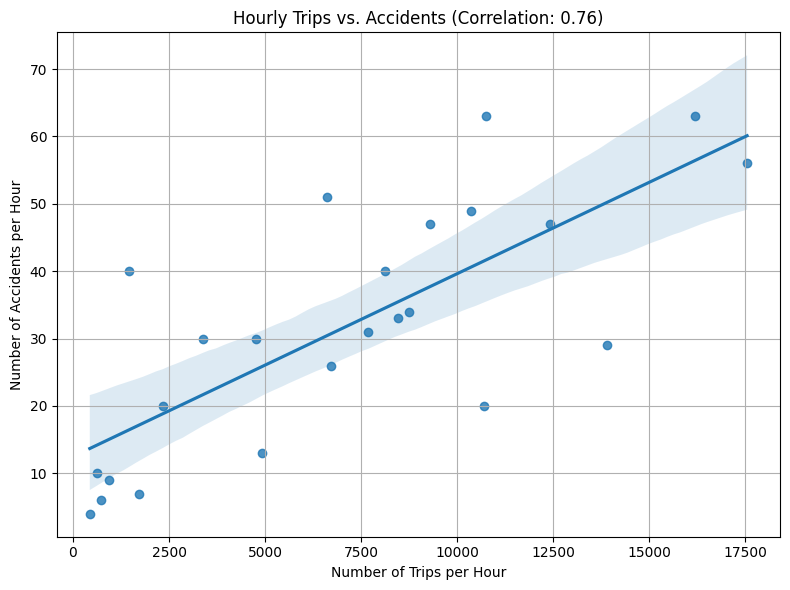

In [19]:
plt.figure(figsize=(8, 6))
sns.regplot(data=hourly_comparison, x='number_of_trips', y='number_of_accidents')
 # Add correlation value to the plot if calculated previously
if 'hourly_correlation' in locals() and hourly_correlation is not None:
    plt.title(f'Hourly Trips vs. Accidents (Correlation: {hourly_correlation:.2f})')
else:
    plt.title('Hourly Trips vs. Accidents')
plt.xlabel('Number of Trips per Hour')
plt.ylabel('Number of Accidents per Hour')
plt.grid(True)
plt.tight_layout()

Die bisherigen Analysen zeigen deutliche  zeitliche Muster sowohl in der Nutzung des CitiBike-Systems als auch im Auftreten von Fahrradunfällen. Um jedoch robuste, kausale Zusammenhänge zwischen CitiBike-Nutzung und Unfallrisiko zu identifizieren und daraus fundierte Empfehlungen für Versicherungen, sind weiterführende analytische Schritte notwendig.

Ein zentrales methodisches Anliegen ist die Kontrolle für sogenannte Confounder , die sowohl die Fahrradnutzung als auch das Unfallgeschehen maßgeblich bestimmen können. Beispiele hierfür sind Wetterbedingungen (Temperatur, Niederschlag, Schnee), Tageszeit, Wochentag, Saison, allgemeines Verkehrsaufkommen (Autos, Fußgänger), das Vorhandensein von Radinfrastruktur, Großveranstaltungen, Feiertage oder Baustellen. Werden diese Faktoren nicht berücksichtigt, besteht die Gefahr, deren Einfluss fälschlicherweise allein der Nutzungsintensität zuzuschreiben.

Umsetzung:
* Erweiterung des Datensatzes durch die Integration externer Datenquellen (z.B. Wetter-APIs, Verkehrszählungen, Feiertagskalender, OpenStreetMap für Radwege).
* Zusammenführung der Daten auf aggregierter Ebene (z.B. pro Stunde und Station/Bezirk).
* Anwendung multivariabler Regressionsmodelle, um die Unfallhäufigkeit als Funktion der CitiBike-Nutzung und der Confounder zu modellieren. 

Durch die Integration zusätzlicher Datenquellen und anderer statistischer Methoden kann die Analyse deutlich vertieft werden. Dies ermöglicht es, differenzierte Risikoprofile für bestimmte Orte, Zeiten und Nutzergruppen zu erstellen und gezielte Präventions- oder Versicherungsangebote zu entwickeln.

Basierend darauf könnten dynamische Tarife oder gezielte Präventionsangebote entwickelt werden:

- Versicherungsprodukte für Nutzer von CitiBike: Bei Buchung des Fahrrads könnten in der App direkt Kurzzeit-Unfallversicherungen oder Haftpflichtversicherungen angeboten werden.
- Präventionsmaßnahmen: Aus den Daten lassen sich Empfehlungen für sicheree Routen, Warnhinweise zu gefährlichen Kreuzungen oder gezielte Aufklärungskampagnen für bestimmte Nutzergruppe anbieten.
- Kundensegmentierung: Identifikation von unterschiedlichen Nutzerprofilen und Risikogruppen identifiziert werden, um maßgeschneiderte Versicherungsangebote zu erstellen. (Dafür müssten mehr Daten über die User zu Verfügung stehen, z.B. Geschlecht oder Alter)
